In [ ]:
!pip install tensorflow tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import glob

In [ ]:
!pip install seaborn

In [3]:
import seaborn as sns

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [1]:
!pip install mtcnn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
from mtcnn.mtcnn import MTCNN

In [ ]:
!pip install tqdm

In [5]:
from tqdm import tqdm

In [ ]:
!pip list

# Collecting positive and anchor images


In [7]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative_upd')
ANC_PATH = os.path.join('data', 'anchor')
print(NEG_PATH)

data\negative_upd


In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
!tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
import uuid

In [ ]:
uuid.uuid1()

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250,:]
    #collect ancohrs
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    #collect positive
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame[120:120+250,200:200+250,:])


# Data augmentation

In [51]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [8]:
import os
import uuid


In [53]:
img_path = os.path.join(ANC_PATH, '869b9594-dd61-11ee-a286-64bc583ce636.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    # print(img_path)
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# face Detection using MTCNN

In [8]:
from mtcnn.mtcnn import MTCNN

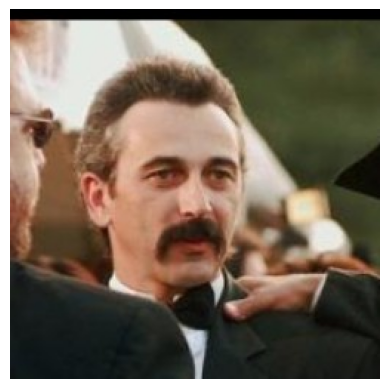

In [9]:
img = cv2.cvtColor(cv2.imread('data/negative/Aaron_Tippin_0001.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

In [10]:
detector = MTCNN()
faces = detector.detect_faces(img)
faces



1/1 [==============================] - 0s 108ms/step


[{'box': [69, 69, 87, 116],
  'confidence': 0.9999731779098511,
  'keypoints': {'left_eye': (105, 112),
   'right_eye': (142, 114),
   'nose': (129, 134),
   'mouth_left': (105, 157),
   'mouth_right': (138, 157)}}]

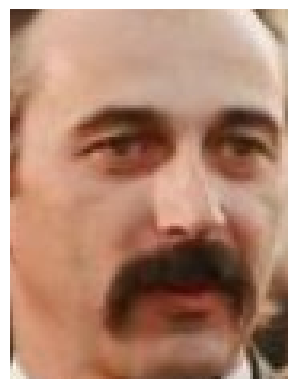

In [10]:
#fetching the (x,y)co-ordinate and (width-->w, height-->h) of the image
x1,y1,w,h = faces[0]['box']
x1, y1 = abs(x1), abs(y1)
x2 = abs(x1+w)
y2 = abs(y1+h)

#locate the co-ordinates of face in the image
store_face = img[y1:y2,x1:x2]
plt.imshow(store_face)
plt.axis('off')
plt.show()

In [11]:
# def save_face(img_path, dest_folder):

#   img = cv2.imread(img_path)
#   detector = MTCNN()
#   faces = detector.detect_faces(img)

#   #fetching the (x,y)co-ordinate and (width-->w, height-->h) of the image
#   x1,y1,w,h = faces[0]['box']
#   x1, y1 = abs(x1), abs(y1)
#   x2 = abs(x1+w)
#   y2 = abs(y1+h)

#   #locate the co-ordinates of face in the image
#   store_face = img[y1:y2,x1:x2]
#   store_face = cv2.resize(store_face, (224, 224)) #The VGGFace model expects a 224x224x3 size face image as input, and it outputs a face embedding vector with a length of 2048.
#   cv2.imwrite(os.path.join(dest_folder, os.path.basename(img_path)), store_face)

def save_face(img_path, dest_folder):
    img = cv2.imread(img_path)
    detector = MTCNN()
    faces = detector.detect_faces(img)

    # Check if faces were detected
    if faces:
        # Get the bounding box of the first detected face
        x1, y1, w, h = faces[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2 = abs(x1 + w)
        y2 = abs(y1 + h)

        # Extract the face from the image
        store_face = img[y1:y2, x1:x2]
        store_face = cv2.resize(store_face, (224, 224))
        cv2.imwrite(os.path.join(dest_folder, os.path.basename(img_path)), store_face)
    else:
        print("No faces detected in the image:", img_path)


## Converting to B&W

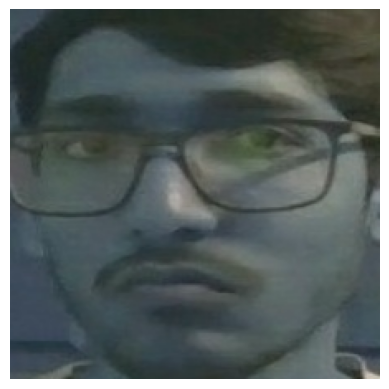

In [8]:
img = cv2.imread('data/positive/faces/42d4fd84-e245-11ee-9bd8-64bc583ce636.jpg')
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.axis('off')
plt.show()

In [10]:
def toBw(img_path, dest_folder):
    img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(dest_folder, os.path.basename(img_path)), gray_img)

In [20]:
images = glob.glob(os.path.join('data/negative_upd/faces', '*.jpg'))

for img in tqdm(images):
  if os.path.isfile(os.path.join('data/negative_upd/faces/bw', os.path.basename(img))):
    pass
  else:
    try:
      toBw(img, 'data/negative_upd/faces/bw')
    except:
      pass

100%|█████████████████████████████████████████████████████████████████████████████| 2093/2093 [00:07<00:00, 289.12it/s]


## Extract faces from our dataset

In [ ]:
images = glob.glob(os.path.join('application_data/verification_images', '*.jpg'))

for img in tqdm(images):
  if os.path.isfile(os.path.join('application_data/verification_images/faces', os.path.basename(img))):
    pass
  else:
    try:
      save_face(img, 'application_data/verification_images/faces')
    except:
      pass

In [12]:
print(len(os.listdir('data/anchor/faces')))
print(len(os.listdir('data/positive/faces')))
print(len(os.listdir('data/negative_upd/faces')))

2389
2006
2093


# Load and Preprocess Images

In [13]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/faces/*.jpg').take(2000)
positive = tf.data.Dataset.list_files(POS_PATH+'/faces/*.jpg').take(2000)
negative = tf.data.Dataset.list_files(NEG_PATH+'/faces/*.jpg').take(2000)
print(len(positive))

2000


In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
dir_test.next()

b'data\\anchor\\faces\\91286ba5-dd61-11ee-a3c3-64bc583ce636.jpg'

## Preprocessing

In [16]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [17]:
img = preprocess('data\\anchor\\faces\\6a4d91ae-e245-11ee-9d86-64bc583ce636.jpg')

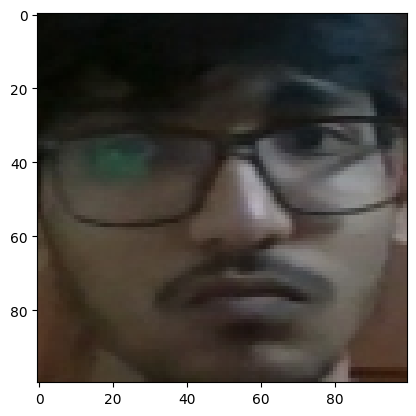

In [18]:
plt.imshow(img)

In [19]:
# dataset.map(preprocess)

In [20]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

# to make the data we pair the positives with anchor and assign them value of 1
# and pair negatives with anchor and assign them value 0

## create labelled dataset

In [21]:
# for more than 1 person pass positive examples of other people along with their anchor

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [22]:
samples = data.as_numpy_iterator()
example = samples.next()

In [23]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

1.0

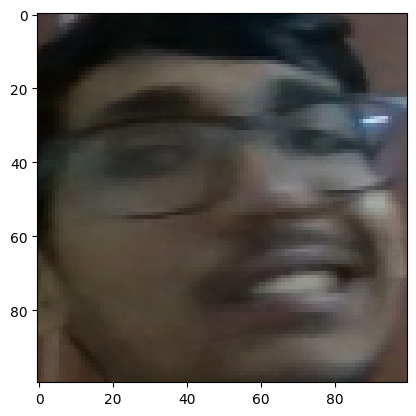

In [24]:
res = preprocess_twin(*example)
plt.imshow(res[1])
res[2]

In [25]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

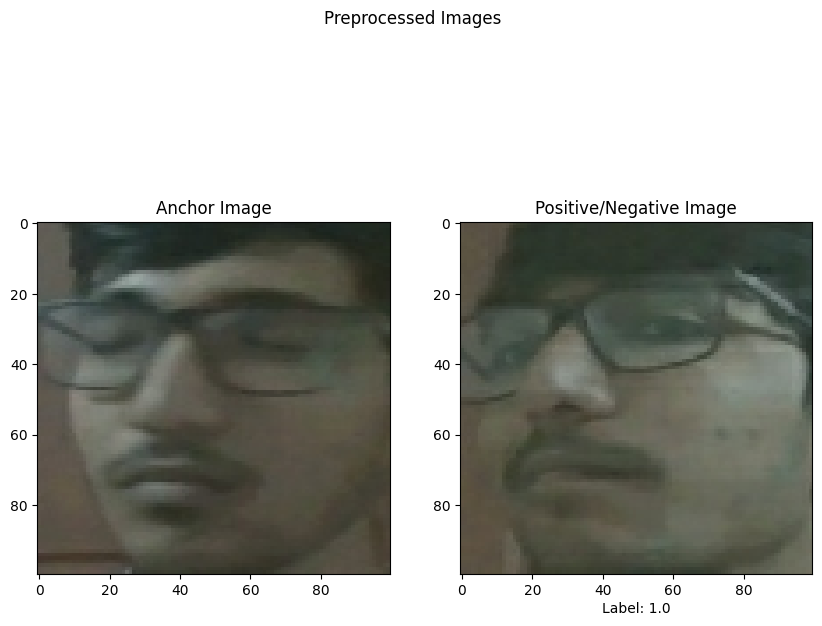

In [26]:
dt = data.as_numpy_iterator()
out = dt.next()

# Unpack the data
anchor_image = out[0]
positive_negative_image = out[1]
y_true = out[2]

# Create a figure
plt.figure(figsize=(10, 8))

# Plot the anchor image
plt.subplot(1, 2, 1)
plt.imshow(anchor_image)
plt.title('Anchor Image')

# Plot the positive/negative image
plt.subplot(1, 2, 2)
plt.imshow(positive_negative_image)
plt.title('Positive/Negative Image')

# Add a title to the entire plot
plt.suptitle('Preprocessed Images')

# Optionally, display the label
plt.text(0.5, -0.1, 'Label: {}'.format(y_true), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Show the plot
plt.show()

In [27]:
# for mulitple people @ part 3 36:08 -> create anchor and positive sets for different people and label them as 1

In [28]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [29]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Creating new Test Dataset

## Collecting positive and anchor images

In [30]:
# Setup paths
POS_PATH_t = os.path.join('test_data', 'positive')
NEG_PATH_t = os.path.join('test_data', 'negative')
ANC_PATH_t = os.path.join('test_data', 'anchor')
print(NEG_PATH_t)

test_data\negative


In [30]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [31]:
import uuid
uuid.uuid1()

UUID('bf696415-0402-11ef-9b79-64bc583ce636')

In [48]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250,:]
    #collect ancohrs
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    #collect positive
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

## Data Augmentation

In [ ]:
for file_name in os.listdir(os.path.join(ANC_PATH_t)):
    img_path = os.path.join(ANC_PATH_t, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    # print(img_path)
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH_t, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH_t)):
    img_path = os.path.join(POS_PATH_t, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    # print(img_path)
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH_t, '{}.jpg'.format(uuid.uuid1())), image.numpy())

## Face Extraction

In [ ]:
images = glob.glob(os.path.join('test_data/positive', '*.jpg'))

for img in tqdm(images):
  if os.path.isfile(os.path.join('test_data/positive/faces', os.path.basename(img))):
    pass
  else:
    try:
      save_face(img, 'test_data/positive/faces')
    except:
      pass

## Creating labelled test data set

In [32]:
anchor_test = tf.data.Dataset.list_files(ANC_PATH_t+'/faces/*.jpg').take(600)
positive_test = tf.data.Dataset.list_files(POS_PATH_t+'/faces/*.jpg').take(600)
negative_test = tf.data.Dataset.list_files(NEG_PATH_t+'/faces/*.jpg').take(600)
print(len(negative_test))

600


In [33]:
positives_test = tf.data.Dataset.zip((anchor_test, positive_test, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor_test)))))
negatives_test = tf.data.Dataset.zip((anchor_test, negative_test, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor_test)))))
data_test = positives_test.concatenate(negatives_test)

In [34]:
# Build dataloader pipeline
data_test = data_test.map(preprocess_twin)
data_test = data_test.cache()
data_test = data_test.shuffle(buffer_size=10000)

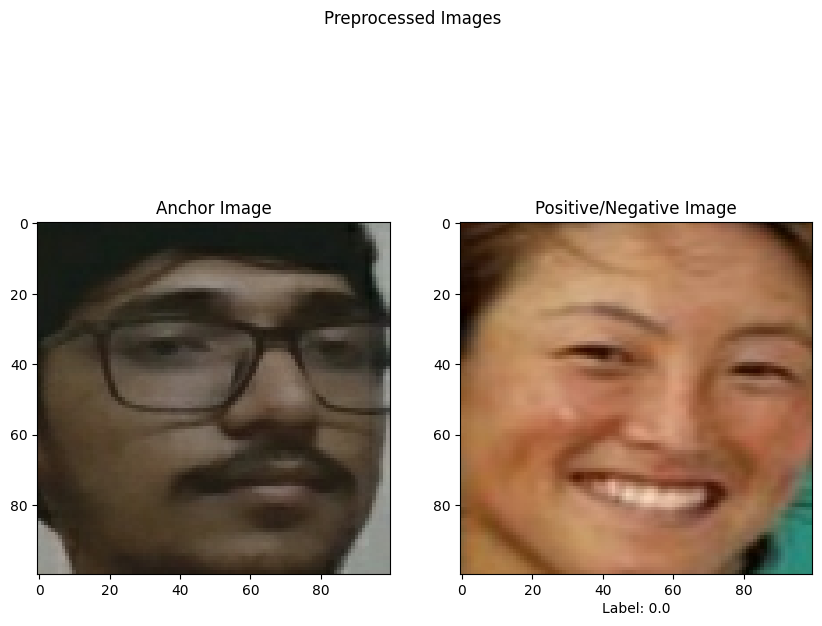

In [35]:
dt = data_test.as_numpy_iterator()
out = dt.next()

# Unpack the data
anchor_image = out[0]
positive_negative_image = out[1]
y_true = out[2]

# Create a figure
plt.figure(figsize=(10, 8))

# Plot the anchor image
plt.subplot(1, 2, 1)
plt.imshow(anchor_image)
plt.title('Anchor Image')

# Plot the positive/negative image
plt.subplot(1, 2, 2)
plt.imshow(positive_negative_image)
plt.title('Positive/Negative Image')

# Add a title to the entire plot
plt.suptitle('Preprocessed Images')

# Optionally, display the label
plt.text(0.5, -0.1, 'Label: {}'.format(y_true), horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

# Show the plot
plt.show()

In [36]:
data_test = data_test.batch(16)
data_test = data_test.prefetch(8)

# Model Engineering

In [37]:
inp = Input(shape=(100, 100, 3), name='input_image')

In [38]:
c1 = Conv2D(64, (10, 10), activation='relu')(inp)
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d_12')>

In [39]:
m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d_6')>

In [40]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
print(c2)
print(m2)

KerasTensor(type_spec=TensorSpec(shape=(None, 40, 40, 128), dtype=tf.float32, name=None), name='conv2d_13/Relu:0', description="created by layer 'conv2d_13'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 20, 128), dtype=tf.float32, name=None), name='max_pooling2d_7/MaxPool:0', description="created by layer 'max_pooling2d_7'")


In [41]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [42]:
mod = Model(inputs=[inp], outputs=[d1], name = 'embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 17, 17, 128)       26

In [39]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    
    # first block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    #second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # fourth block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name = 'embedding')


In [40]:
embedding = make_embedding()

In [41]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 17, 17, 128)       26

# Distance Layer

In [42]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [43]:
l1 = L1Dist()

In [44]:
l1

# Siamese Model

In [45]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
imp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [46]:
siamese_layer = L1Dist()
distances = siamese_layer(imp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_8')>

In [47]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [48]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [49]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Training

In [50]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [168]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [169]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [170]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
Y = batch_1[2]
print(len(X))
print((Y).shape)

2
(16,)


In [171]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [55]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [173]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [174]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)

# Model Evaluation

In [51]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, TrueNegatives, FalsePositives, F1Score

In [56]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [57]:
test_var = test_data.as_numpy_iterator().next()

In [58]:
# making predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 465ms/step


array([[0.50031483],
       [0.5009765 ],
       [0.501536  ],
       [0.5010514 ],
       [0.5004622 ],
       [0.5005672 ],
       [0.5004825 ],
       [0.50039893],
       [0.5014162 ],
       [0.5013194 ],
       [0.50083834],
       [0.50114125],
       [0.5007592 ],
       [0.50051206],
       [0.5007677 ],
       [0.5010641 ]], dtype=float32)

In [59]:
# Classifying results to 0 and 1 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [60]:
y_true

array([0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

In [61]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [62]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.5

In [63]:
def specifity(y_true, y_hat, th):
    tn = TrueNegatives(thresholds = th)
    tn.update_state(y_true, y_hat)
    tn = tn.result().numpy()
    
    fp = FalsePositives(thresholds = th)
    fp.update_state(y_true, y_hat)
    fp = fp.result().numpy()
    
    sp = tn / (tn + fp)
    return sp

In [64]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

In [65]:


def model_eval(model, test_data, th):
    y_true_list = []
    y_hat_list = []

    for test_input_batch, test_val_batch, y_true_batch in test_data.as_numpy_iterator():
        y_true_list.append(y_true_batch)
        y_hat_batch = model.predict([test_input_batch, test_val_batch])
        y_hat_list.append(y_hat_batch)

    y_true = np.concatenate(y_true_list, axis=0)
    y_hat = np.concatenate(y_hat_list, axis=0)

    m = Recall(thresholds=th)
    m.update_state(y_true, y_hat)
    recall = m.result().numpy()

    m2 = Precision(thresholds=th)
    m2.update_state(y_true, y_hat)
    precision = m2.result().numpy()

    sp = specifity(y_true, y_hat, th)

    f1_score = 2 * ((recall * precision) / (recall + precision))

    m4 = BinaryAccuracy(threshold=th)
    m4.update_state(y_true, y_hat)
    accuracy = m4.result().numpy()
    
    conf = tf.math.confusion_matrix(y_true, y_hat)
    
    # print("Recall: ", recall)
    # print("Precision: ", precision)
    # print("Specificity: ", sp)
    # print("F1Score: ", f1_score)
    # print("Accuracy: ", accuracy)
    # print("Confusion Matrix: ", conf)
    plot_confusion_matrix(conf)
    metrics = {
        "Recall": recall,
        "Precision": precision,
        "Specificity": sp,
        "F1Score": f1_score,
        "Accuracy": accuracy
    }

    return metrics

In [89]:
def plot_metrics_bar(metrics):
    metrics_names = list(metrics.keys())
    metrics_values = list(metrics.values())

    plt.figure(figsize=(10, 6))
    plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Model Evaluation Metrics')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [66]:
def calc_confusionMatrix(model, test_data):
    y_true_list = []
    y_hat_list = []

    for test_input_batch, test_val_batch, y_true_batch in test_data.as_numpy_iterator():
        y_true_list.append(y_true_batch)
        y_hat_batch = model.predict([test_input_batch, test_val_batch])
        y_hat_list.append(y_hat_batch)

    y_true = np.concatenate(y_true_list, axis=0)
    y_hat = np.concatenate(y_hat_list, axis=0)
    conf = tf.math.confusion_matrix(y_true, y_hat)

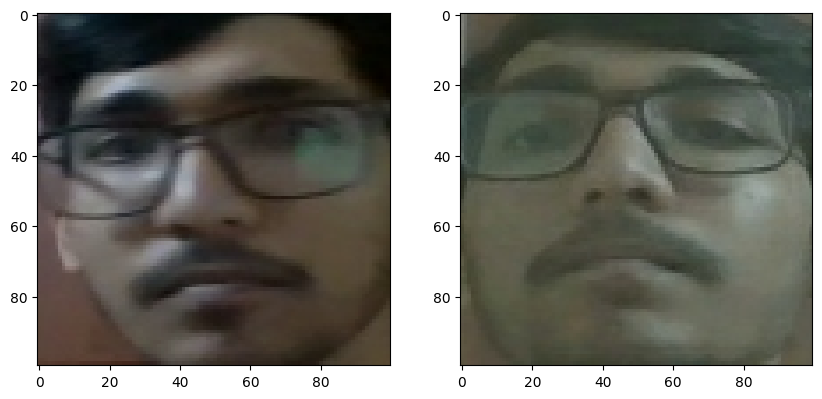

1.0


In [67]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()
print(y_true[1])

In [ ]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [ ]:
siamese_model.save('siamesemodelv2.h5')

In [73]:
siamese_model.save('siamesemodelv3.h5')

D:\FacialRecognition\facialrecognition\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [243]:
siamese_model.save('siamesemodelv4.h5')

D:\FacialRecognition\facialrecognition\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [68]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [69]:
model2 = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [70]:
model3 = tf.keras.models.load_model('siamesemodelv3.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [71]:
model4 = tf.keras.models.load_model('siamesemodelv4.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [72]:
y_true

array([0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

In [73]:
y1 = model.predict([test_input, test_val])
y1 = [1 if prediction > 0.5 else 0 for prediction in y1]
print(y1)

1/1 [==============================] - 0s 450ms/step
[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]


In [74]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [75]:
y2 = model2.predict([test_input, test_val])
y2 = [1 if prediction > 0.5 else 0 for prediction in y2]
print(y2)

1/1 [==============================] - 0s 489ms/step
[0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]


In [76]:
model2.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [77]:
y3 = model3.predict([test_input, test_val])
y3 = [1 if prediction > 0.5 else 0 for prediction in y2]
print(y3)

1/1 [==============================] - 0s 453ms/step
[0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0]


1/1 [==============================] - 0s 395ms/step


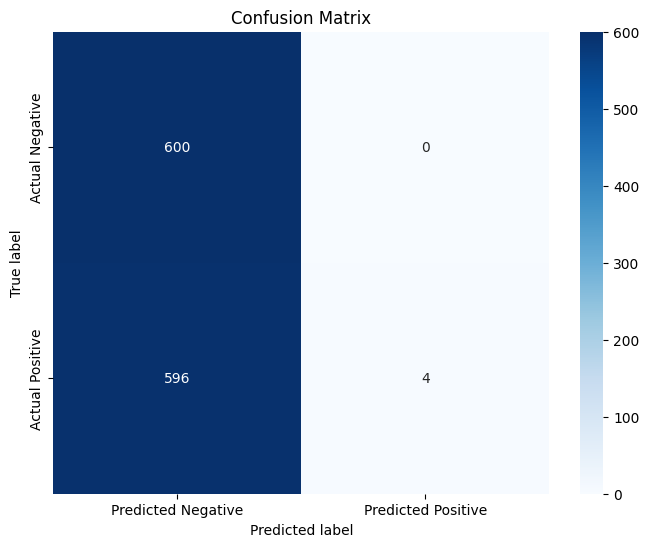

{'Recall': 0.5316667,
 'Precision': 0.8739726,
 'Specificity': 0.92333335,
 'F1Score': 0.6611399054527283,
 'Accuracy': 0.7275}

In [78]:
model_eval(model4, data_test, 0.1)
# model_eval(model3, test_data, 0.1)
# model_eval(model2, test_data, 0.1)


1/1 [==============================] - 0s 393ms/step


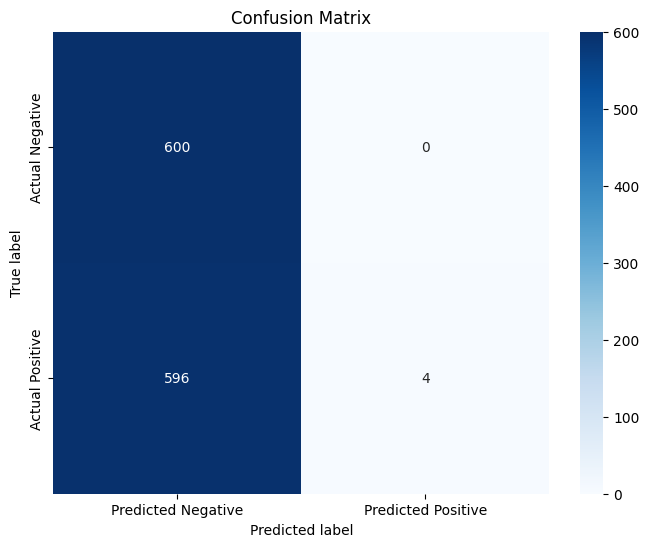

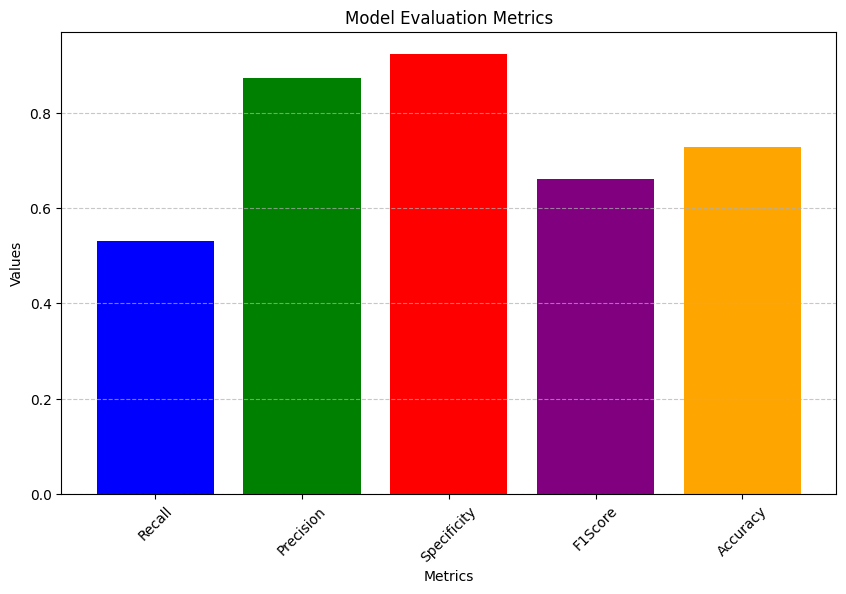

1/1 [==============================] - 0s 369ms/step


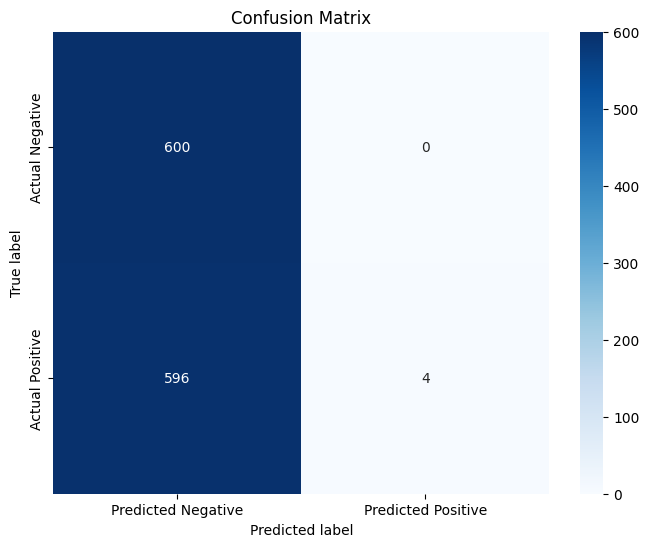

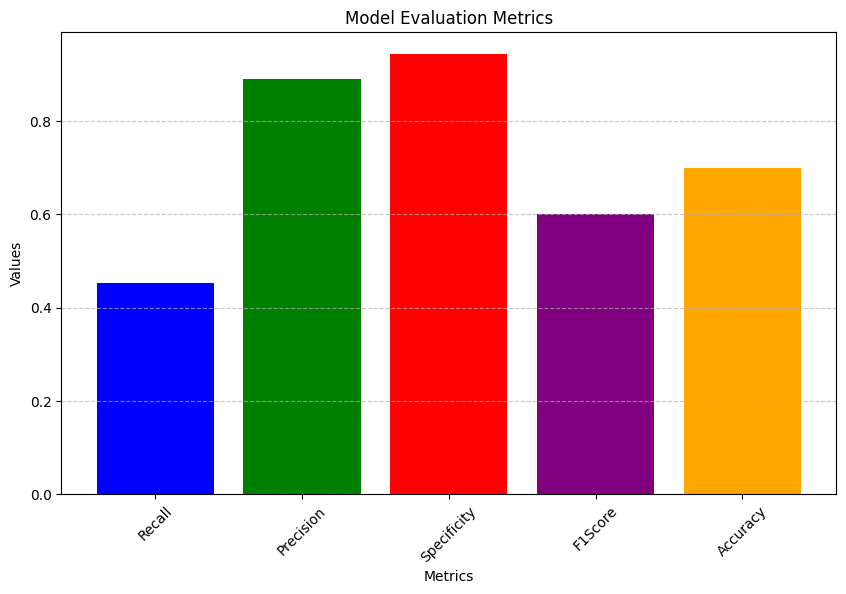

1/1 [==============================] - 0s 386ms/step


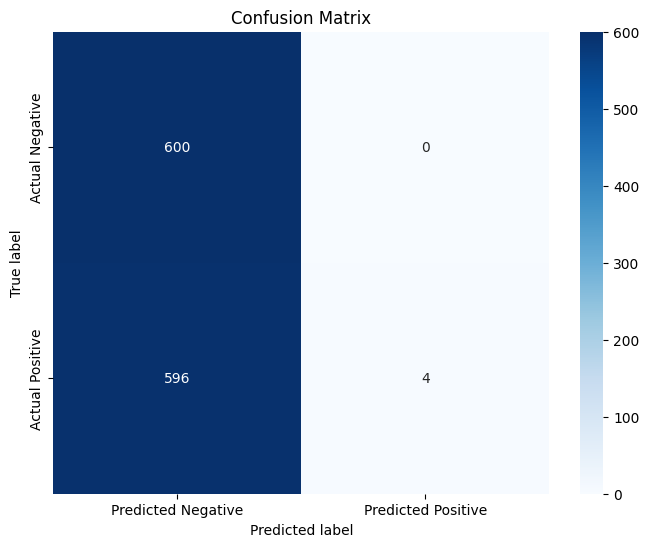

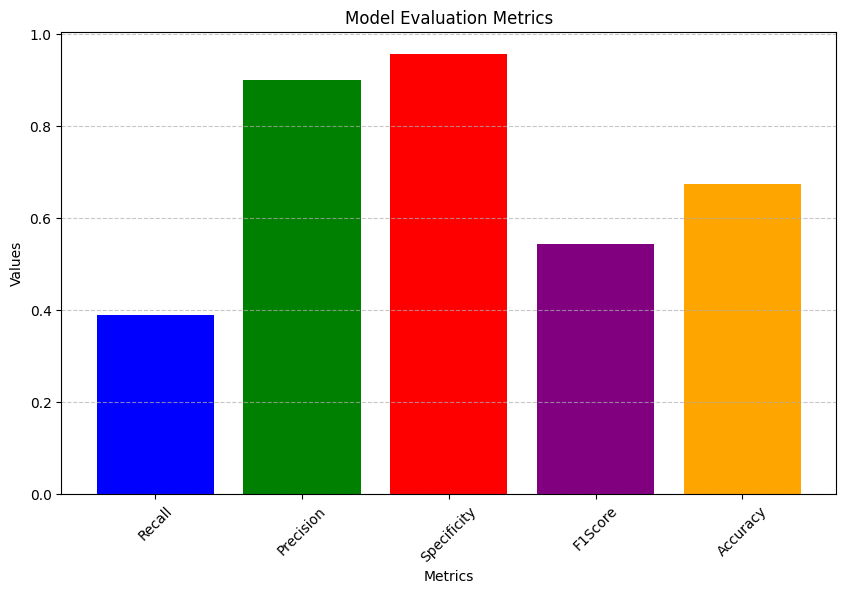

1/1 [==============================] - 0s 370ms/step


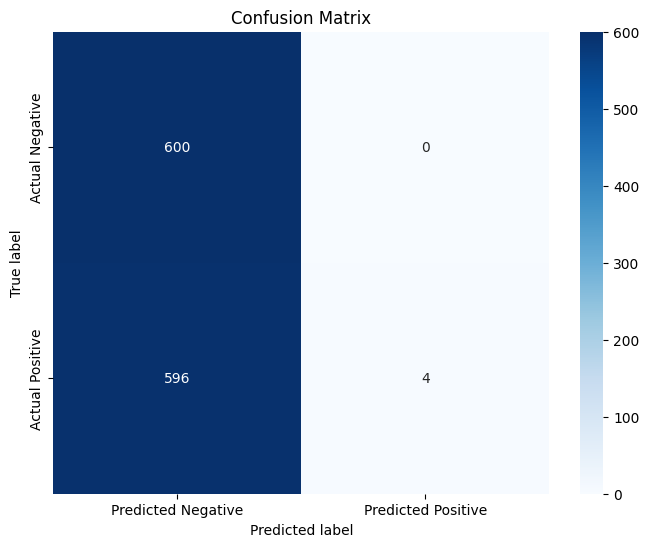

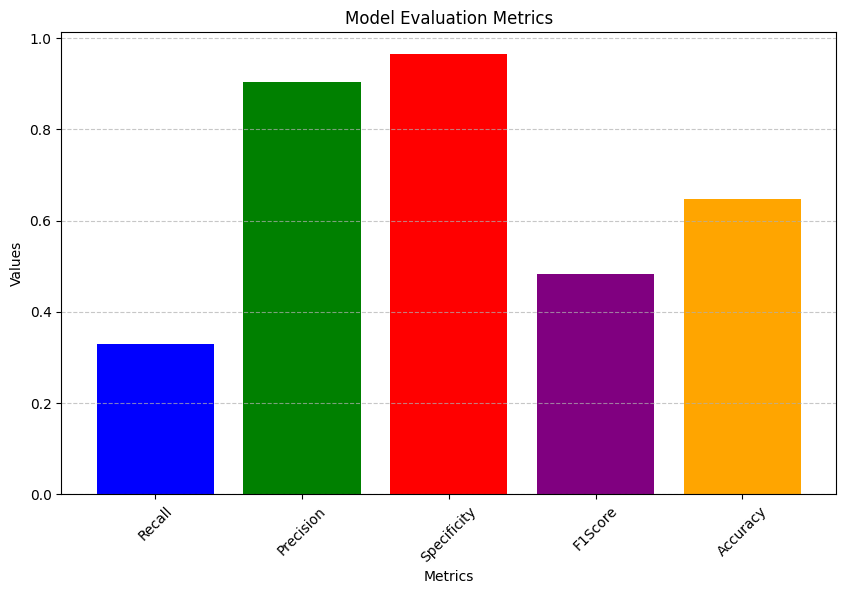

1/1 [==============================] - 0s 388ms/step


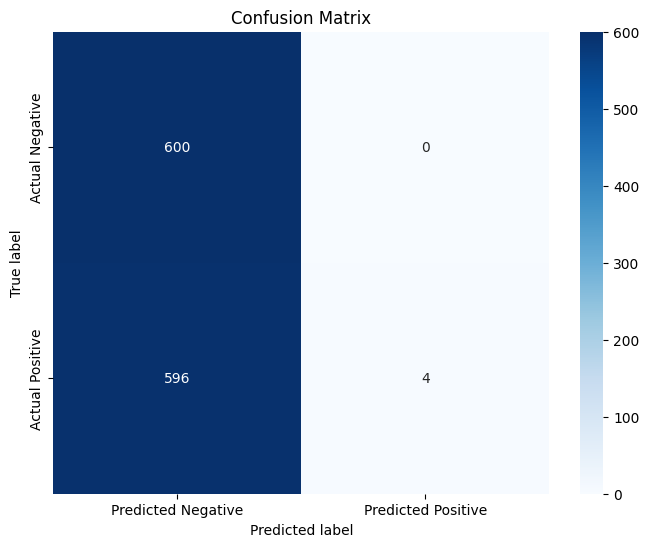

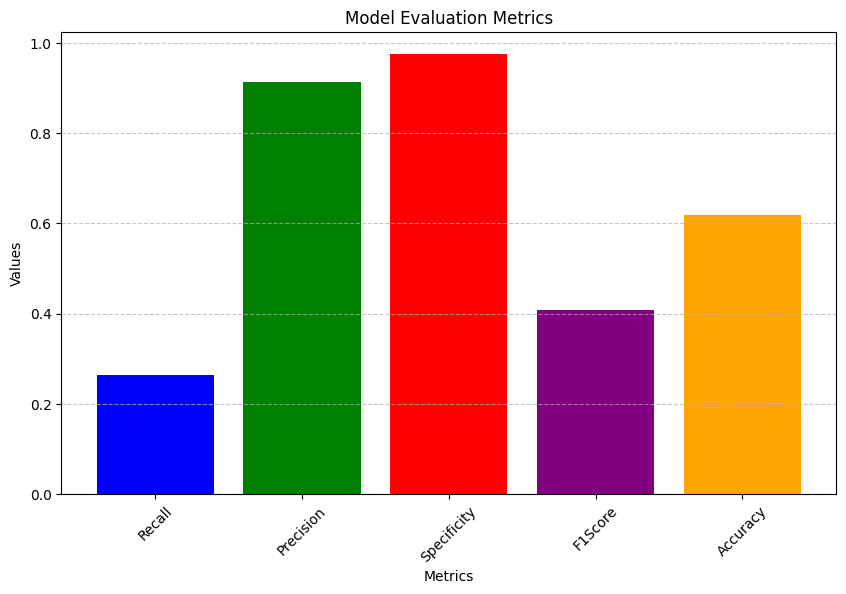

In [93]:

metrics = model_eval(model4, data_test, 0.6)
    

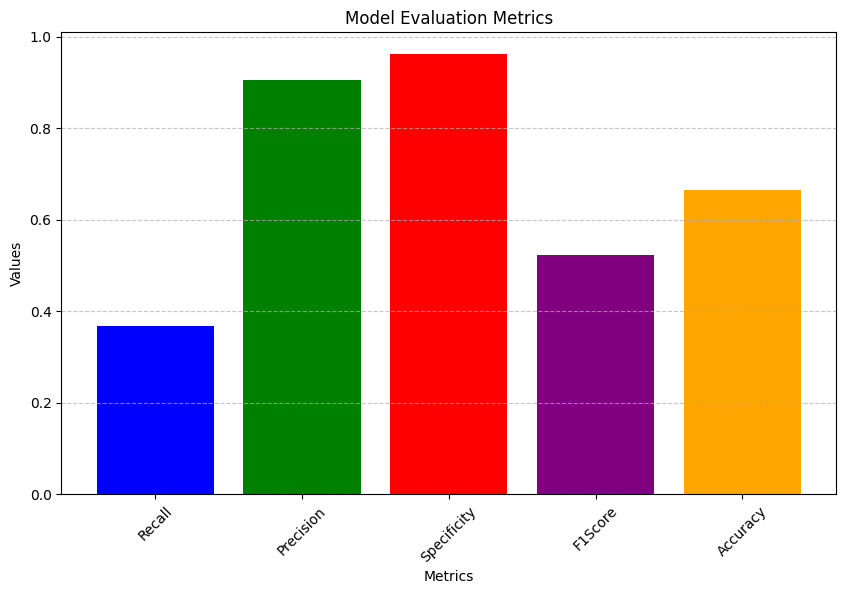

In [91]:
plot_metrics_bar(metrics)

1/1 [==============================] - 0s 372ms/step


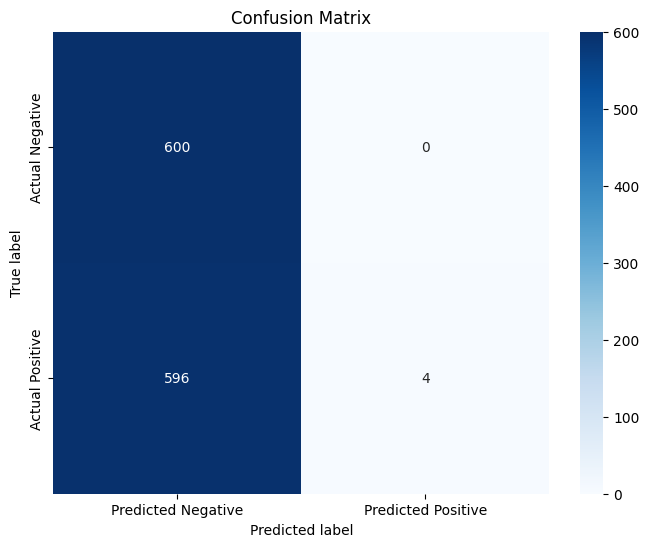

1/1 [==============================] - 0s 437ms/step


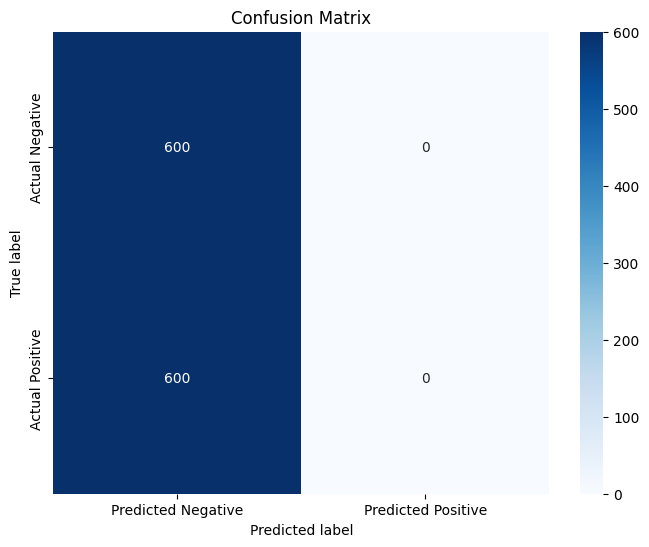

1/1 [==============================] - 0s 366ms/step


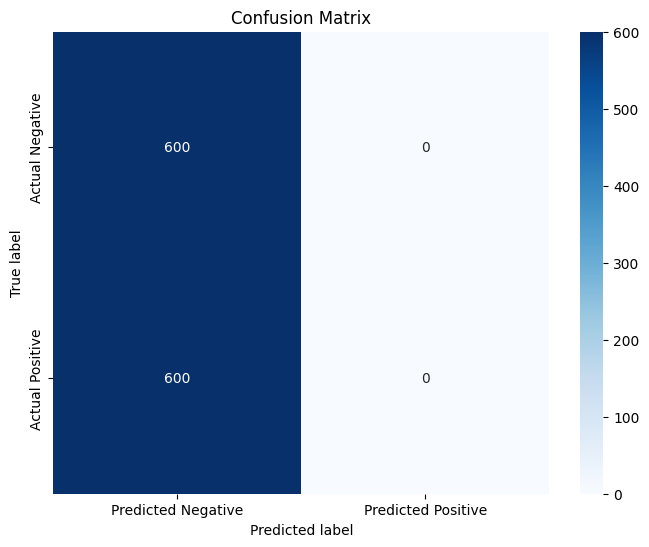

1/1 [==============================] - 0s 377ms/step


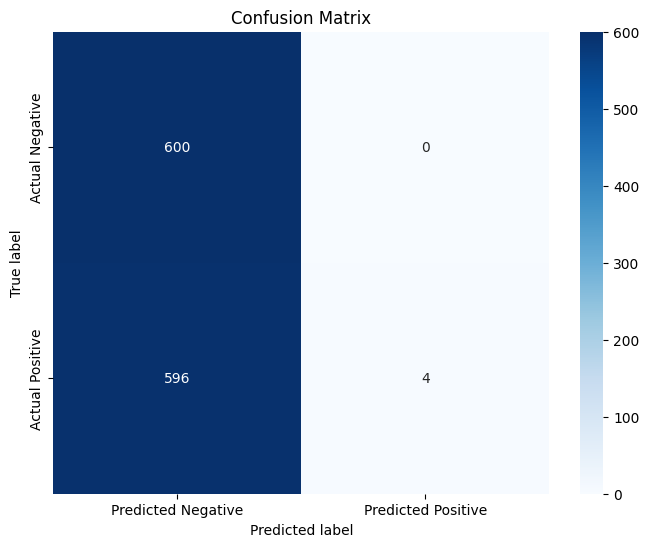

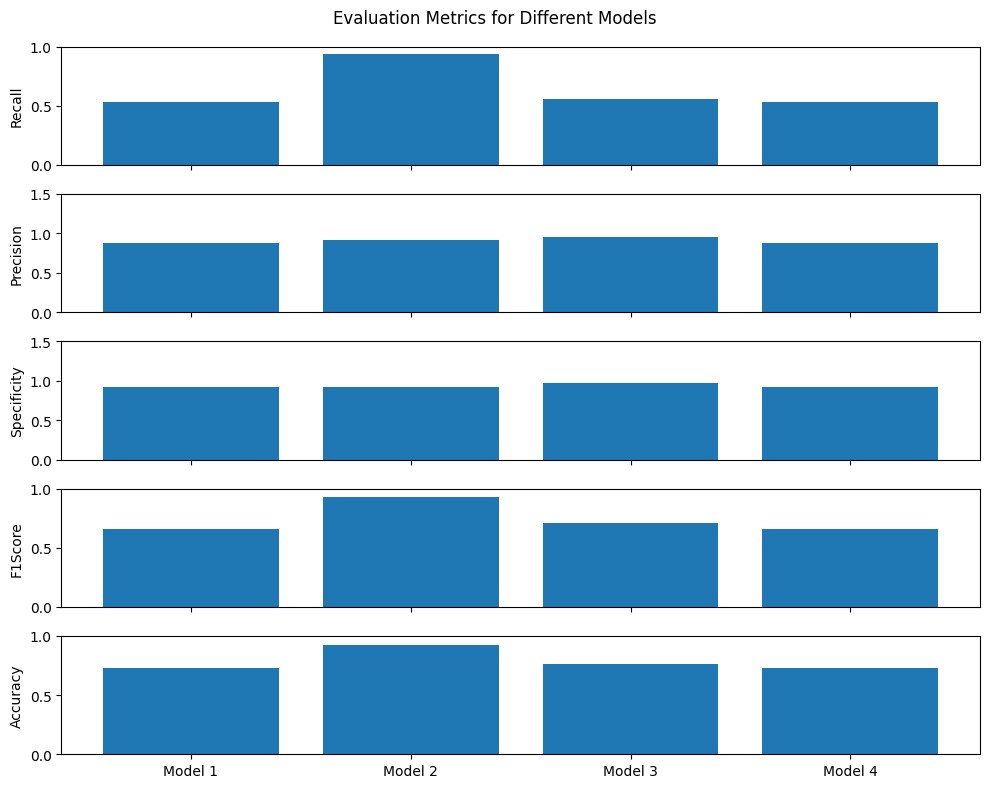

In [94]:
models = [model, model2, model3, model4]
model_names = ["Model 1", "Model 2", "Model 3", "Model 4"]
all_metrics = []

for model, model_name in zip(models, model_names):
    metrics = model_eval(model, data_test, 0.1)
    all_metrics.append(metrics)

metrics_names = list(all_metrics[0].keys())
num_metrics = len(metrics_names)

fig, axs = plt.subplots(num_metrics, figsize=(10, 8), sharex=True)
fig.suptitle('Evaluation Metrics for Different Models')

for i, metric_name in enumerate(metrics_names):
    values = [metrics[metric_name] for metrics in all_metrics]
    axs[i].bar(model_names, values)
    axs[i].set_ylabel(metric_name)
    axs[i].set_yticks([round(j, 1) for j in 
                       list(axs[i].get_yticks())])

plt.tight_layout()
plt.show()

In [119]:
# Testing over all test data
# Initialize lists to store true labels and predicted labels
def test_all(model):
    true_labels = []
    predicted_labels = []

    # Iterate over all batches in the test data
    for batch in test_data:
        # Extract input and validation samples from the batch
        test_input, test_val, y_true_batch = batch

        # Predict labels for the batch
        y_hat_batch = model.predict([test_input, test_val])

        y_hat_batch = [1 if prediction > 0.04 else 0 for prediction in y_hat_batch]





        # Append true labels and predicted labels
        true_labels.extend(y_true_batch)
        predicted_labels.extend(y_hat_batch)

    # Convert lists to numpy arrays for easier comparison
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate accuracy
    accuracy = np.mean(true_labels == predicted_labels)
    print(true_labels)
    print(predicted_labels)
    print("Accuracy:", accuracy)

In [ ]:
test_all(model)

In [ ]:
test_all(model2)

In [ ]:
test_all(model3)

In [ ]:
test_all(model4)

# Real Time Test

In [246]:
verif_folder = os.path.join('application_data', 'verification_images', 'faces')
len(os.listdir(verif_folder))

49

In [52]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    
    for image in os.listdir(os.path.join('application_data', 'verification_images', 'faces')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', 'faces', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    for result in results:
        print(result)
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    print(detection)
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images', 'faces'))) 
    print(verification)
    verified = verification > verification_threshold
    
    return results, verified

In [53]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        save_face('application_data/input_image/input_image.jpg', 'application_data/input_image')
        # Run verification
        results, verified = verify(model2, 0.1, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 56ms/step
[[0.46898475]]
[[0.64506805]]
[[0.5600552]]
[[0.67174107]]
[[0.50234056]]
[[0.4645838]]
[[0.57576585]]
[[0.7448597]]
[[0.8077631]]
[[0.72792375]]
[[0.69554085]]
[[0.87874395]]
[[0.46756133]]
[[0.5973968]]
[[0.4248515]]
[[0.8171403]]
[[0.9448619]]
[[0.5339116]]
[[0.6122148]]
[[0.86588377]]
[[0.8318516]]
[[0.44894552]]
[[0.68721384]]
[[0.8252029]]
[[0.7155316]]
[[0.65174377]]
[[0.69465053]]
[[0.6542296]]
[[0.8728529]]
[[0.9099408]]
[[0.9091481]]
[[0.8936888]]
[[0.83609176]]
[[0.9238893]]
[[0.9193551]]
[[0.6370923]]
[[0.49252027]]
[[0.3824286]]
[[0.99724275]]
[[0.8984539]]
[[0.95548886]]
[[0.8218711]]
[[0.78064317]]
[[0.75684863]]
[[0.8169567]]
[[0.9997939]]
[[0.999892]]
[[0.99932724]]
[[0.9965129]]
49
1.0
True
1/1 [==============================] - 0s 51ms/step
[[0.09231798]]
[[0.13524394]]
[[0.10836305]]
[[0.1359268]]
[[0.11629924]]
[[0.10083921]]
[[0.13232864]]
[[0.22372063]]
[[0.279435]]
[[0.26874888]]
[[0.2471921]]
[[0.27064607]]
[[

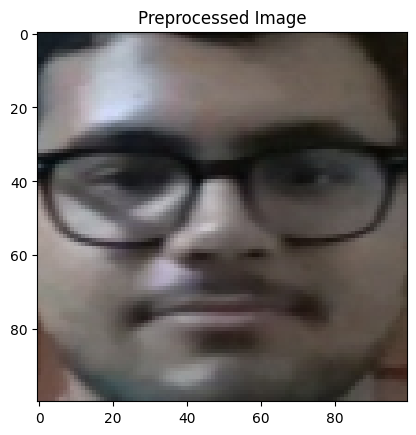

In [54]:
inp = os.path.join('application_data', 'input_image', 'input_image.jpg')
out = preprocess(inp)
plt.imshow(out)
plt.title('Preprocessed Image')
plt.show()

In [ ]:
results, verified = verify(model, 0.95, 0.92)
print(verified)

In [55]:
results, verified = verify(model2, 0.1, 0.5)
print(verified)

1/1 [==============================] - 0s 56ms/step
[[0.47835928]]
[[0.6593887]]
[[0.5926665]]
[[0.727737]]
[[0.4937645]]
[[0.46050718]]
[[0.58170646]]
[[0.7301848]]
[[0.7938106]]
[[0.7526332]]
[[0.74032205]]
[[0.9362341]]
[[0.4817929]]
[[0.62346613]]
[[0.6132199]]
[[0.614254]]
[[0.9151995]]
[[0.53531706]]
[[0.5254647]]
[[0.7897356]]
[[0.8314686]]
[[0.5240675]]
[[0.6703922]]
[[0.8377561]]
[[0.7665053]]
[[0.5700236]]
[[0.7025994]]
[[0.65132684]]
[[0.4757145]]
[[0.6159279]]
[[0.7230362]]
[[0.57740295]]
[[0.5190428]]
[[0.86894035]]
[[0.67861825]]
[[0.664191]]
[[0.5429591]]
[[0.5631715]]
[[0.99781847]]
[[0.89268124]]
[[0.8701505]]
[[0.5859734]]
[[0.7696871]]
[[0.58190054]]
[[0.44387004]]
[[0.99997616]]
[[0.99991226]]
[[0.999514]]
[[0.9982874]]
49
1.0
True


In [ ]:
results, verified = verify(model3, 0.04, 0.5)
print(verified)


In [222]:
results, verified = verify(model4, 0.1, 0.5)
print(verified)


1/1 [==============================] - 0s 119ms/step
[[6.521588e-08]]
[[3.014912e-06]]
[[2.3755493e-07]]
[[9.972877e-08]]
[[2.3213563e-07]]
[[1.536228e-06]]
[[5.2174903e-07]]
[[3.0844407e-07]]
[[3.9582574e-07]]
[[5.823501e-08]]
[[4.5733337e-08]]
[[3.6464965e-07]]
[[1.137649e-05]]
[[6.0362672e-05]]
[[7.7455226e-08]]
[[1.4584289e-06]]
[[1.1089004e-07]]
[[2.0121226e-07]]
[[6.245035e-08]]
[[7.768959e-08]]
[[1.0910757e-07]]
[[4.0917652e-07]]
[[3.4457761e-07]]
[[8.5770426e-07]]
[[1.2387577e-06]]
[[2.8654479e-06]]
[[2.2794734e-06]]
[[2.3303803e-06]]
[[7.87552e-07]]
[[1.5038132e-06]]
[[2.2820552e-06]]
[[2.644575e-06]]
[[3.5872565e-06]]
[[2.492327e-06]]
[[4.1105295e-06]]
[[4.389548e-06]]
[[2.3090097e-07]]
[[3.7720136e-07]]
[[9.632328e-06]]
[[1.1098522e-06]]
[[2.409455e-06]]
[[1.7576072e-06]]
[[1.5148865e-06]]
[[5.5410794e-07]]
[[1.895906e-06]]
[[1.7076633e-07]]
[[3.4803172e-08]]
[[1.4967422e-07]]
[[9.968738e-06]]
0
0.0
False


In [208]:
res_num = np.array(results)
res_num = res_num.flatten()
res_num.shape

(49,)

In [209]:
min = res_num.min()
max = res_num.max()
print(min, max)
count = np.sum(res_num > 0.04)
print(count)

7.760594e-05 0.12258198
17


In [147]:
aryan = res_num

In [157]:
aryan = np.append(aryan, res_num)
aryan

array([6.8224870e-02, 4.0483195e-02, 4.3493174e-02, 5.2540425e-02,
       4.1311774e-01, 5.1032531e-01, 1.4704572e-01, 3.0656388e-01,
       6.0838324e-01, 9.8775554e-01, 9.8631305e-01, 1.1681922e-01,
       4.6906145e-03, 6.0641402e-03, 9.9537587e-01, 4.6471134e-01,
       9.9559164e-01, 9.1820776e-02, 3.6015369e-02, 8.3075061e-02,
       1.3934782e-01, 5.3324229e-03, 6.9525796e-03, 1.2453805e-02,
       1.3627556e-02, 7.4075353e-03, 4.6211011e-03, 1.3978879e-02,
       3.5155628e-02, 1.4447105e-02, 2.4811581e-02, 3.8040694e-02,
       6.0823534e-02, 3.6003403e-02, 5.5123836e-02, 1.2937974e-02,
       7.4992418e-02, 5.3003490e-02, 2.3893829e-02, 7.2711469e-03,
       1.1079415e-02, 5.2780602e-02, 2.6337303e-02, 7.3669814e-02,
       5.4523684e-03, 2.0360255e-01, 5.0132215e-01, 1.4338082e-02,
       5.5892146e-03, 4.1800945e-08, 2.8915208e-08, 5.3843376e-08,
       5.8589187e-08, 1.9451285e-07, 2.3633694e-07, 8.1513711e-08,
       1.8737703e-07, 4.8016011e-07, 6.2603513e-06, 5.2191049e